In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'


입장 조건
* 롱 포지션:

    - 가격 > 200 SMA: 현재 가격은 200일 단순 이동 평균(SMA)보다 높아야 합니다.
    - MACD > 신호선: MACD 값이 신호선보다 높아 상승 모멘텀을 나타냅니다.
    - RSI > 50: 상대강도지수(RSI)가 50을 초과하여 강세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

* 매도 포지션:

    - 가격 < 200 SMA: 현재 가격이 200일 SMA보다 낮습니다.
    - MACD < 시그널선: MACD 값이 시그널선보다 작아 하락 모멘텀을 나타냅니다.
    - RSI < 50: RSI가 50 미만으로 약세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

종료 조건
* 롱 포지션:

    - 손절매: 진입 가격보다 낮은 특정 비율(예: 0.5% 또는 조정된 가격)로 설정합니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때, 이는 추세 반전 가능성을 나타냅니다.

* 매도 포지션:

    - 손절매: 진입 가격보다 높은 특정 비율로 설정됩니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때.


In [2]:
# backtest = pd.read_csv("./data/Grouped_Backtest_Results_by_Indicator.csv")
from backtest import back_testing
backtest = back_testing()

    Position  Entry_RSI  Exit_RSI  Max_Profit_RSI  Entry_MACD  Exit_MACD  \
0      Short      34.11     33.04           40.45      -20.52     -23.52   
1      Short      31.02     39.75           40.45      -26.71     -26.46   
2      Short      33.25     32.67           40.45      -29.47     -31.86   
3      Short      29.40     29.16           40.45      -35.45     -38.02   
4      Short      32.80     29.60           40.45      -12.19     -23.18   
..       ...        ...       ...             ...         ...        ...   
213     Long      62.37     43.95           61.69       19.32      11.37   
214     Long      57.58     46.52           61.69        9.04      11.17   
215     Long      58.26     65.58           61.69        0.44      26.80   
216     Long      67.06     73.11           61.69       29.88      36.43   
217     Long      63.75     64.49           61.69       42.21      41.94   

     Max_Profit_MACD  Entry_Signal_Line  Exit_Signal_Line  \
0              -9.37      

In [3]:
backtest_long = backtest.query("Position == 'Long'")
backtest_short = backtest.query("Position == 'Short'")

In [4]:
backtest_long.describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00
mean,67.18,64.92,77.16,39.49,44.15,179.32,28.64,34.12,148.73,94.53,81.48,89.11,62900.40,62827.04,-73.36,1210.67
std,6.52,9.97,8.12,37.54,37.06,78.18,33.59,32.08,65.79,13.09,24.13,5.82,612.06,611.53,47.65,850.54
min,55.70,42.57,51.81,0.44,1.35,8.60,-18.62,-5.07,-2.17,75.03,8.65,55.35,61813.81,61838.96,-241.42,-28.22
25%,62.37,59.46,67.33,17.49,26.23,176.83,10.23,17.66,153.51,85.69,73.64,91.42,62492.48,62401.32,-100.44,280.93
50%,66.61,66.94,81.84,31.09,33.67,224.12,23.31,25.55,186.36,92.40,86.07,91.42,62783.88,62706.51,-71.29,1305.65
75%,70.51,71.05,81.84,48.08,50.33,224.12,33.98,37.26,186.36,101.60,97.02,91.42,63416.80,63326.22,-45.80,1884.82
max,84.42,85.93,81.84,224.12,216.51,224.12,186.36,191.97,191.97,149.88,132.22,103.36,64417.29,64353.88,85.26,2656.38


# 숏 분석

## 테스트 중 손실
- 탈출 전략이 잘못 적용 되었다는 것을 확인할 수 있음

In [5]:
backtest_short.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
0,Short,34.11,33.04,40.45,-20.52,-23.52,-9.37,-19.68,-20.45,-9.21,-2.60,-0.11,6.50,2024-10-05 13:41:00+00:00,62144.24,2024-10-05 13:42:00+00:00,62211.63,-67.39,442.10,2024-10-05 21:05:00+00:00
1,Short,31.02,39.75,40.45,-26.71,-26.46,-9.37,-21.70,-22.65,-9.21,-2.66,23.24,6.50,2024-10-05 13:43:00+00:00,62123.10,2024-10-05 13:44:00+00:00,62228.38,-105.28,420.96,2024-10-05 21:05:00+00:00
2,Short,33.25,32.67,40.45,-29.47,-31.86,-9.37,-24.02,-25.59,-9.21,-1.87,1.86,6.50,2024-10-05 13:45:00+00:00,62109.77,2024-10-05 13:46:00+00:00,62179.88,-70.10,407.63,2024-10-05 21:05:00+00:00
3,Short,29.40,29.16,40.45,-35.45,-38.02,-9.37,-27.56,-29.65,-9.21,-5.98,1.35,6.50,2024-10-05 13:47:00+00:00,62079.05,2024-10-05 13:48:00+00:00,62151.65,-72.60,376.91,2024-10-05 21:05:00+00:00
4,Short,32.80,29.60,40.45,-12.19,-23.18,-9.37,-9.94,-15.34,-9.21,-14.88,2.98,6.50,2024-10-05 14:10:00+00:00,62073.51,2024-10-05 16:16:00+00:00,62099.75,-26.23,371.37,2024-10-05 21:05:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Short,27.59,31.64,18.45,-44.80,-46.56,-78.46,-34.32,-36.77,-49.43,-8.86,6.87,-2.93,2024-10-08 05:27:00+00:00,62392.69,2024-10-08 05:28:00+00:00,62484.48,-91.79,398.34,2024-10-08 07:20:00+00:00
205,Short,34.30,31.52,18.45,-19.87,-23.58,-78.46,-19.14,-20.03,-49.43,-3.59,-10.54,-2.93,2024-10-08 05:52:00+00:00,62358.84,2024-10-08 05:53:00+00:00,62414.73,-55.88,364.49,2024-10-08 07:20:00+00:00
206,Short,30.90,24.38,18.45,-26.57,-33.00,-78.46,-21.34,-23.67,-49.43,-3.46,-20.88,-2.93,2024-10-08 05:54:00+00:00,62335.51,2024-10-08 05:55:00+00:00,62355.29,-19.78,341.16,2024-10-08 07:20:00+00:00
208,Short,34.81,38.15,18.45,-5.09,-25.04,-78.46,12.57,-6.86,-49.43,-14.07,12.15,-2.93,2024-10-08 07:07:00+00:00,62301.77,2024-10-08 07:11:00+00:00,62369.37,-67.60,307.42,2024-10-08 07:20:00+00:00


In [6]:
backtest_short.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00
mean,30.76,31.87,23.54,-32.64,-40.12,-59.78,-21.45,-27.64,-38.39,-8.84,3.42,-2.11,62637.40,62724.83,-87.43,713.21
std,5.95,6.22,8.67,28.57,28.10,30.46,22.29,20.96,19.04,8.47,13.33,6.43,587.26,601.22,140.81,513.21
min,17.96,18.36,18.45,-150.60,-160.77,-84.40,-108.87,-119.25,-76.06,-35.75,-20.88,-18.41,61753.16,61814.50,-1153.70,-14.31
25%,27.26,28.73,18.45,-39.93,-43.02,-78.46,-28.92,-31.02,-49.43,-13.49,-6.07,-2.93,62102.09,62203.69,-84.57,325.99
50%,32.21,32.10,18.45,-25.88,-30.95,-78.46,-19.47,-21.73,-49.43,-5.69,1.83,-2.93,62560.49,62605.85,-63.63,566.14
75%,34.87,36.00,27.15,-12.67,-23.97,-16.18,-6.73,-15.40,-9.21,-2.83,10.79,-2.93,63149.29,63358.32,-48.33,1154.94
max,41.18,47.77,40.45,-5.09,-16.57,-9.37,12.57,1.88,-2.30,-0.54,46.74,16.45,63743.44,63801.69,-4.24,1749.09


## 테스트 중 이익

In [7]:
backtest_short.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
163,Short,26.29,21.12,18.45,-89.73,-109.00,-78.46,-73.81,-80.85,-49.43,-3.98,-15.15,-2.93,2024-10-07 18:46:00+00:00,63013.42,2024-10-07 18:47:00+00:00,62945.98,67.43,1019.07,2024-10-08 07:20:00+00:00
170,Short,39.21,31.11,18.45,-17.84,-28.90,-78.46,-7.17,-11.51,-49.43,-2.55,-26.68,-2.93,2024-10-07 20:16:00+00:00,63190.69,2024-10-07 20:17:00+00:00,63171.70,18.99,1196.34,2024-10-08 07:20:00+00:00
178,Short,30.01,20.16,18.45,-42.71,-62.97,-78.46,-41.16,-45.52,-49.43,-25.56,-41.49,-2.93,2024-10-07 22:53:00+00:00,62915.47,2024-10-07 22:54:00+00:00,62804.41,111.06,921.12,2024-10-08 07:20:00+00:00
179,Short,18.94,12.66,18.45,-80.82,-114.50,-78.46,-52.58,-64.97,-49.43,-21.63,-30.99,-2.93,2024-10-07 22:55:00+00:00,62695.22,2024-10-07 22:56:00+00:00,62511.82,183.40,700.87,2024-10-08 07:20:00+00:00
181,Short,21.97,16.17,18.45,-157.76,-193.71,-78.46,-103.67,-121.68,-49.43,-1.60,-14.08,-2.93,2024-10-07 22:59:00+00:00,62419.87,2024-10-07 23:00:00+00:00,62197.15,222.72,425.52,2024-10-08 07:20:00+00:00
209,Short,23.15,19.02,18.45,-56.95,-68.91,-78.46,-35.50,-42.18,-49.43,-1.98,-9.43,-2.93,2024-10-08 07:18:00+00:00,62120.92,2024-10-08 07:19:00+00:00,62119.99,0.93,126.57,2024-10-08 07:20:00+00:00


In [8]:
backtest_short.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,26.59,20.04,18.45,-74.30,-96.33,-78.46,-52.31,-61.12,-49.43,-9.55,-22.97,-2.93,62725.93,62625.18,100.75,731.58
std,7.25,6.23,0.00,48.44,57.25,0.00,33.30,37.77,0.00,10.98,12.21,0.00,398.81,420.71,88.96,398.81
min,18.94,12.66,18.45,-157.76,-193.71,-78.46,-103.67,-121.68,-49.43,-25.56,-41.49,-2.93,62120.92,62119.99,0.93,126.57
25%,22.26,16.88,18.45,-87.50,-113.13,-78.46,-68.50,-76.88,-49.43,-17.22,-29.91,-2.93,62488.70,62275.82,31.10,494.35
50%,24.72,19.59,18.45,-68.88,-88.95,-78.46,-46.87,-55.24,-49.43,-3.26,-20.91,-2.93,62805.34,62658.12,89.25,810.99
75%,29.08,20.88,18.45,-46.27,-64.45,-78.46,-36.91,-43.01,-49.43,-2.12,-14.34,-2.93,62988.93,62910.59,165.31,994.58
max,39.21,31.11,18.45,-17.84,-28.90,-78.46,-7.17,-11.51,-49.43,-1.60,-9.43,-2.93,63190.69,63171.70,222.72,1196.34


# 롱

## 테스트 중 손실

In [9]:
backtest_long.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
5,Long,61.82,48.28,81.84,1.53,4.69,224.12,-8.49,0.76,186.36,104.85,54.44,91.42,2024-10-05 16:25:00+00:00,62222.21,2024-10-05 16:30:00+00:00,62095.73,-126.48,2247.98,2024-10-07 14:24:00+00:00
11,Long,62.84,49.16,81.84,7.41,7.69,224.12,1.54,8.21,186.36,104.27,43.19,91.42,2024-10-05 17:34:00+00:00,62068.78,2024-10-05 17:46:00+00:00,61969.92,-98.86,2401.41,2024-10-07 14:24:00+00:00
16,Long,70.22,63.28,81.84,36.89,36.61,224.12,27.52,29.34,186.36,92.03,78.08,91.42,2024-10-05 21:23:00+00:00,61953.74,2024-10-05 21:24:00+00:00,61853.67,-100.07,2516.45,2024-10-07 14:24:00+00:00
17,Long,65.73,69.04,81.84,2.54,26.15,224.12,-2.33,16.09,186.36,86.86,85.15,91.42,2024-10-05 22:02:00+00:00,61971.55,2024-10-05 22:09:00+00:00,61947.66,-23.89,2498.64,2024-10-07 14:24:00+00:00
18,Long,68.77,69.36,81.84,26.97,27.54,224.12,18.26,20.12,186.36,81.23,79.33,91.42,2024-10-05 22:10:00+00:00,62021.39,2024-10-05 22:11:00+00:00,61949.98,-71.41,2448.80,2024-10-07 14:24:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,Long,62.37,43.95,61.69,19.32,11.37,31.16,16.16,16.99,27.14,96.72,8.65,77.90,2024-10-08 09:01:00+00:00,62493.27,2024-10-08 09:08:00+00:00,62331.72,-161.55,174.21,2024-10-08 11:51:00+00:00
214,Long,57.58,46.52,61.69,9.04,11.17,31.16,-0.60,14.38,27.14,81.77,31.33,77.90,2024-10-08 09:25:00+00:00,62462.17,2024-10-08 09:37:00+00:00,62361.18,-100.99,205.31,2024-10-08 11:51:00+00:00
215,Long,58.26,65.58,61.69,0.44,26.80,31.16,-1.83,13.18,27.14,77.86,90.35,77.90,2024-10-08 09:49:00+00:00,62490.10,2024-10-08 09:54:00+00:00,62479.75,-10.35,177.38,2024-10-08 11:51:00+00:00
216,Long,67.06,73.11,61.69,29.88,36.43,31.16,16.52,20.50,27.14,90.01,102.29,77.90,2024-10-08 09:55:00+00:00,62566.27,2024-10-08 09:56:00+00:00,62547.24,-19.03,101.21,2024-10-08 11:51:00+00:00


## 테스트 중 이익

In [10]:
backtest_long.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
15,Long,57.64,68.40,81.84,1.03,25.30,224.12,-5.50,18.25,186.36,93.62,95.25,91.42,2024-10-05 21:08:00+00:00,61813.81,2024-10-05 21:19:00+00:00,61838.96,25.16,2656.38,2024-10-07 14:24:00+00:00
45,Long,68.15,76.37,81.84,7.49,29.74,224.12,-4.98,19.42,186.36,105.16,111.30,91.42,2024-10-06 14:15:00+00:00,62364.92,2024-10-06 14:27:00+00:00,62384.26,19.34,2105.27,2024-10-07 14:24:00+00:00
53,Long,71.90,78.01,81.84,60.28,67.37,224.12,50.07,53.53,186.36,90.72,106.25,91.42,2024-10-06 14:46:00+00:00,62605.69,2024-10-06 14:47:00+00:00,62611.48,5.79,1864.50,2024-10-07 14:24:00+00:00
117,Long,61.62,71.77,81.84,6.81,30.52,224.12,-0.09,17.37,186.36,94.75,106.81,91.42,2024-10-07 08:02:00+00:00,63611.95,2024-10-07 08:08:00+00:00,63633.77,21.81,858.24,2024-10-07 14:24:00+00:00
132,Long,59.36,68.32,81.84,4.57,31.01,224.12,-0.92,11.10,186.36,98.85,108.42,91.42,2024-10-07 13:18:00+00:00,63037.85,2024-10-07 13:21:00+00:00,63059.08,21.23,1432.34,2024-10-07 14:24:00+00:00
143,Long,69.68,73.02,81.84,97.91,110.13,224.12,93.79,97.05,186.36,103.83,108.67,91.42,2024-10-07 14:10:00+00:00,63776.19,2024-10-07 14:11:00+00:00,63783.04,6.84,694.00,2024-10-07 14:24:00+00:00
146,Long,69.01,74.87,81.84,138.63,150.65,224.12,122.63,128.24,186.36,85.12,100.71,91.42,2024-10-07 14:16:00+00:00,63916.76,2024-10-07 14:17:00+00:00,64002.02,85.26,553.43,2024-10-07 14:24:00+00:00
147,Long,75.44,77.85,81.84,159.81,171.74,224.12,134.55,141.99,186.36,96.46,99.29,91.42,2024-10-07 14:18:00+00:00,64097.27,2024-10-07 14:19:00+00:00,64102.71,5.44,372.92,2024-10-07 14:24:00+00:00
149,Long,81.38,83.24,81.84,202.23,216.51,224.12,167.02,176.92,186.36,97.47,98.59,91.42,2024-10-07 14:22:00+00:00,64344.20,2024-10-07 14:23:00+00:00,64353.88,9.68,125.99,2024-10-07 14:24:00+00:00
185,Long,61.49,67.04,65.73,36.75,45.88,64.05,23.34,27.85,48.28,90.01,106.17,80.29,2024-10-08 00:32:00+00:00,62535.87,2024-10-08 00:33:00+00:00,62539.68,3.81,282.64,2024-10-08 03:01:00+00:00


# 시각화

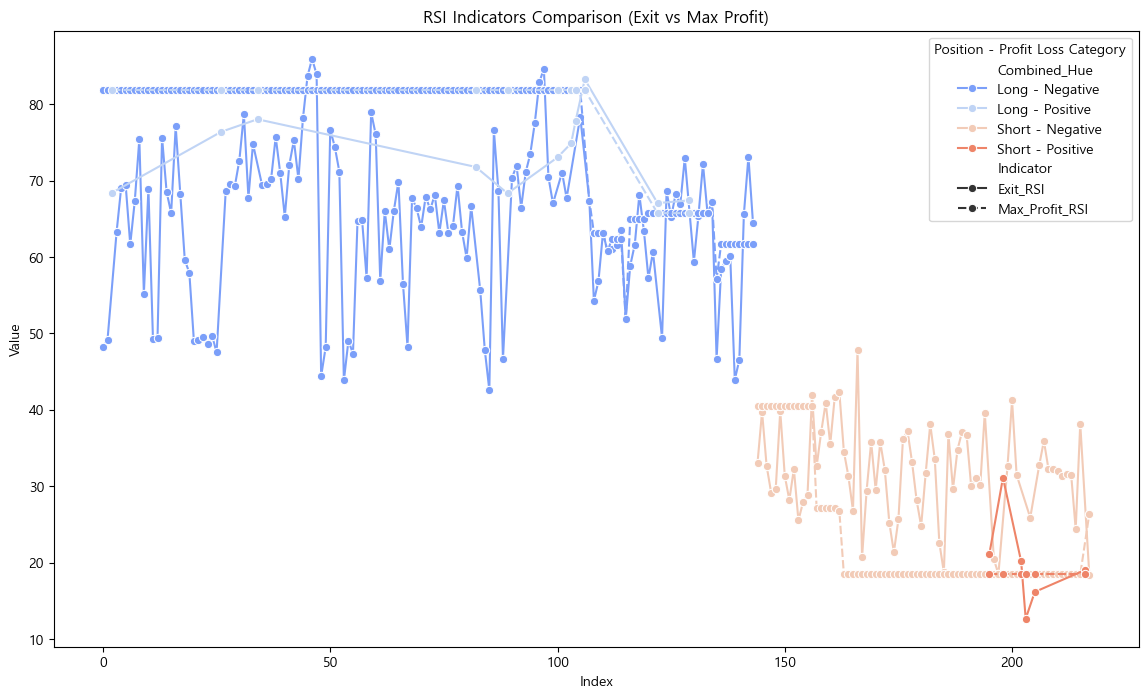

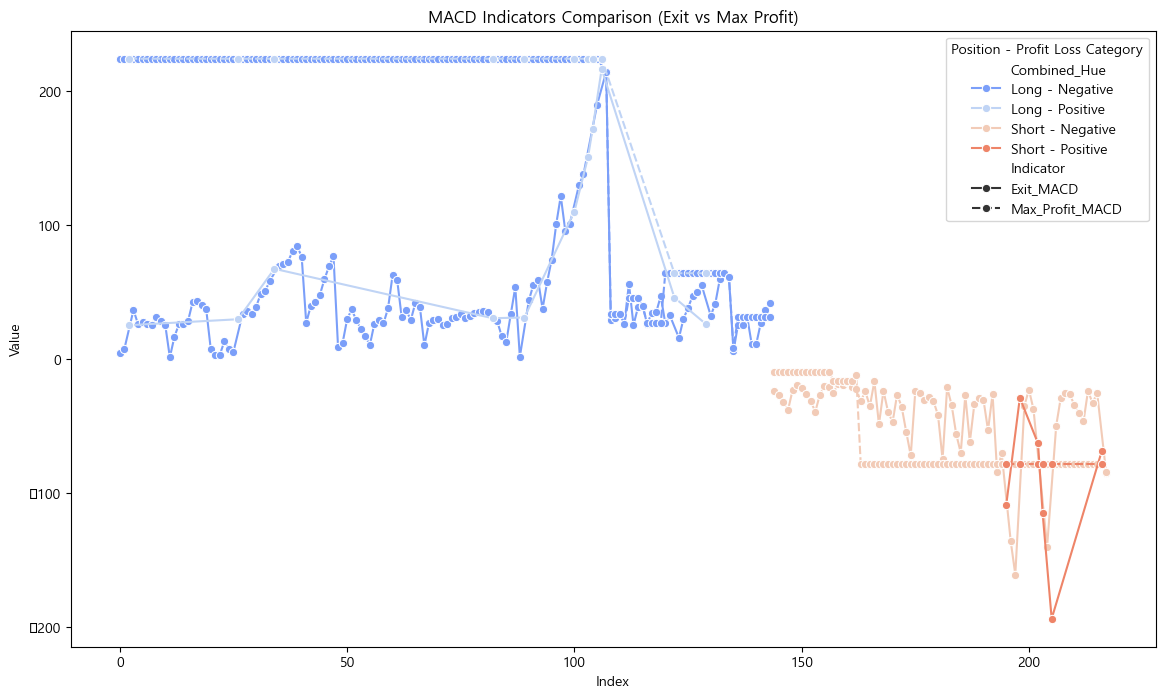

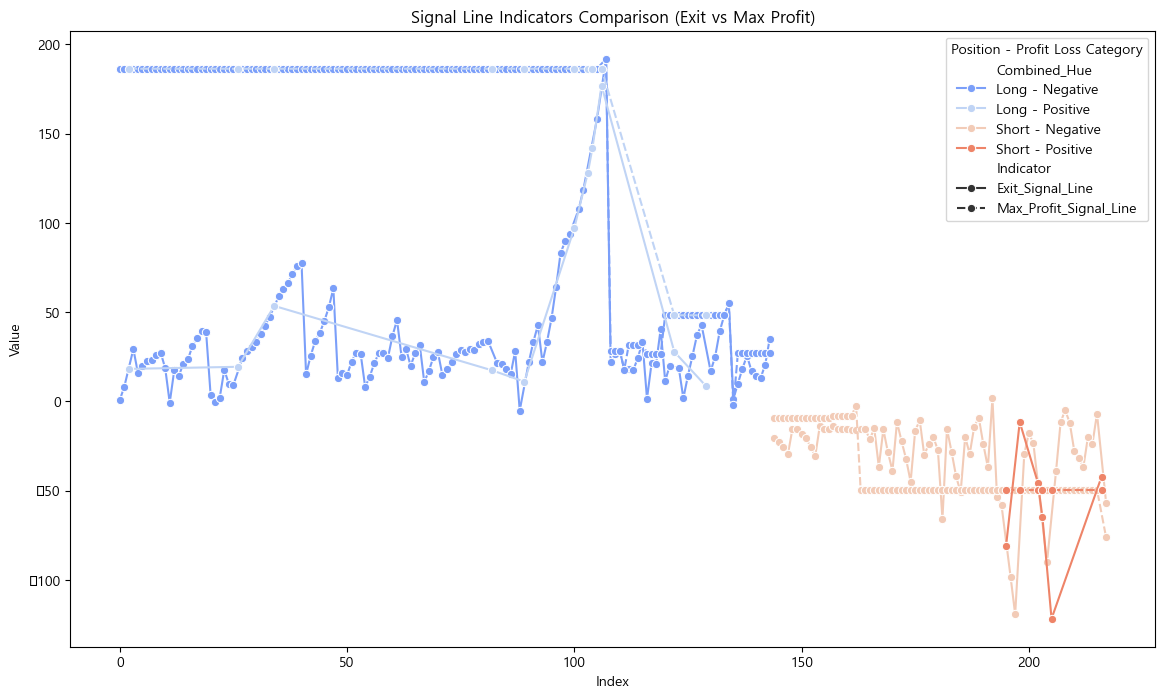

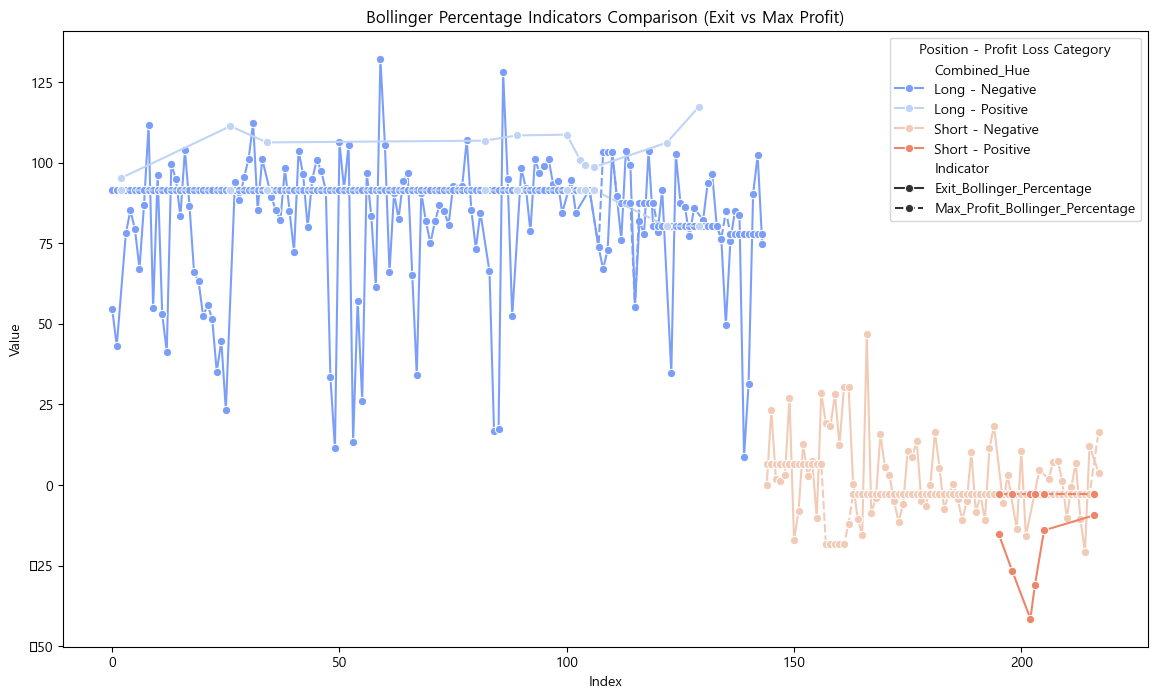

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have combined_data from backtest_long and backtest_short data
combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Position and Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")
plot_data["Combined_Hue"] = plot_data["Position"] + " - " + plot_data["Profit_Loss_Category"]

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot RSI indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_RSI", "Max_Profit_RSI"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("RSI Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot MACD indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_MACD", "Max_Profit_MACD"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("MACD Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Signal Line indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Signal_Line", "Max_Profit_Signal_Line"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Signal Line Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Bollinger Percentage indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Bollinger Percentage Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()


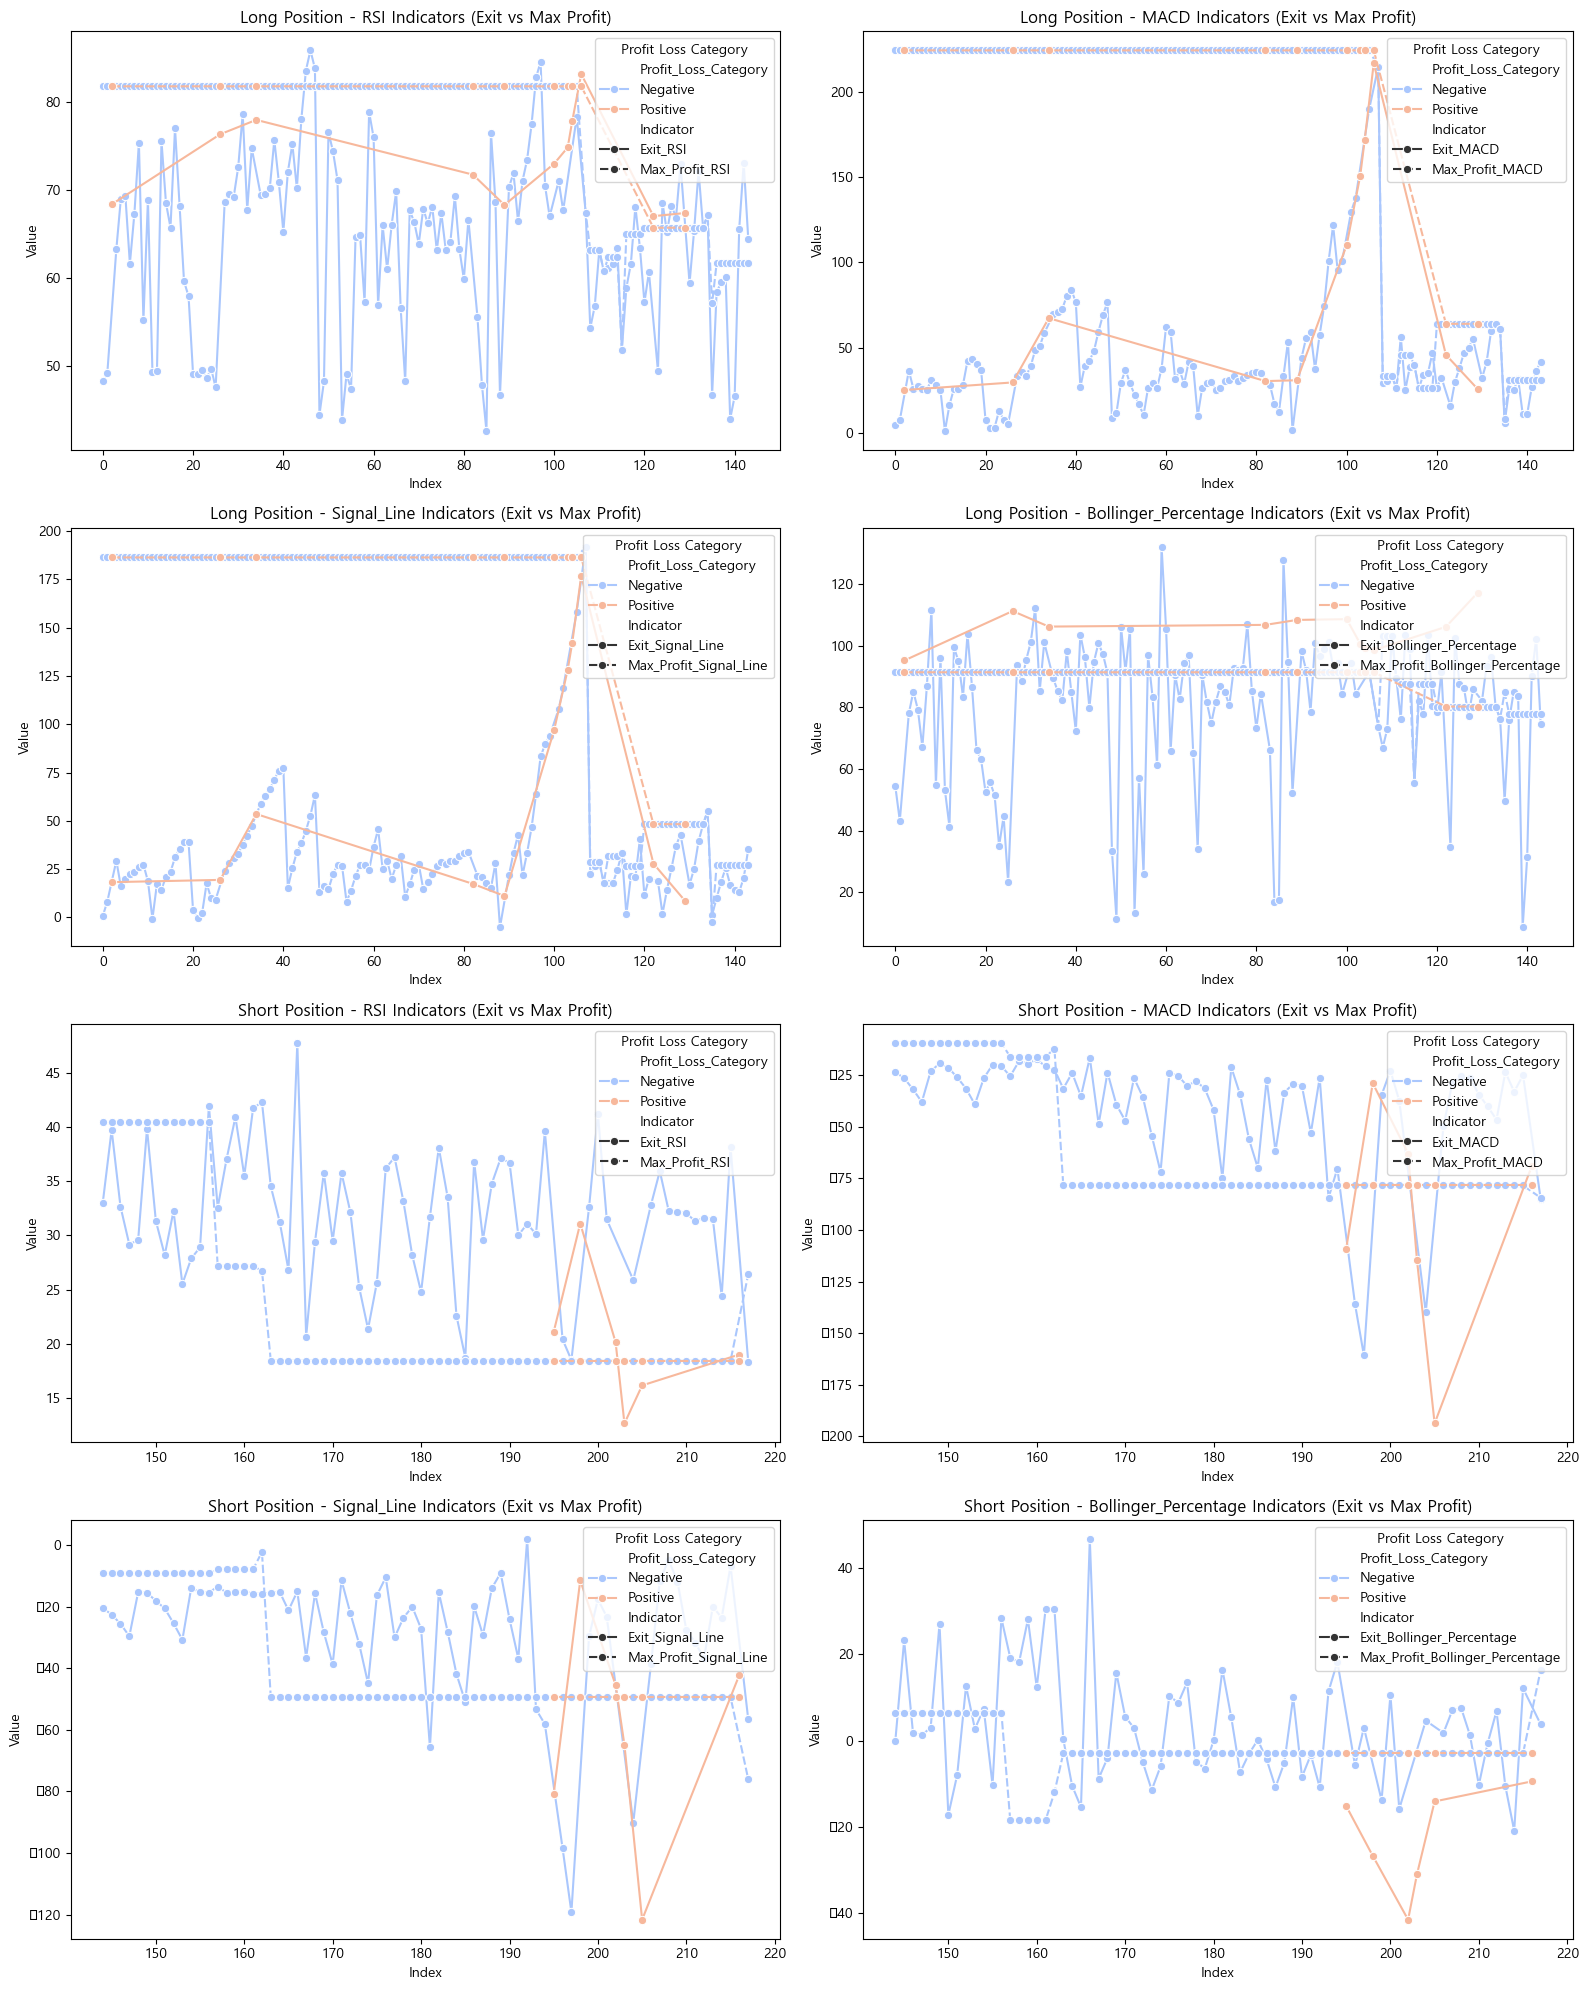

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 8 graphs
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs = {
    "RSI": ["Exit_RSI", "Max_Profit_RSI"],
    "MACD": ["Exit_MACD", "Max_Profit_MACD"],
    "Signal_Line": ["Exit_Signal_Line", "Max_Profit_Signal_Line"],
    "Bollinger_Percentage": ["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"]
}

# Loop through positions and indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific indicator pair
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", style="Indicator", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Indicators (Exit vs Max Profit)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()


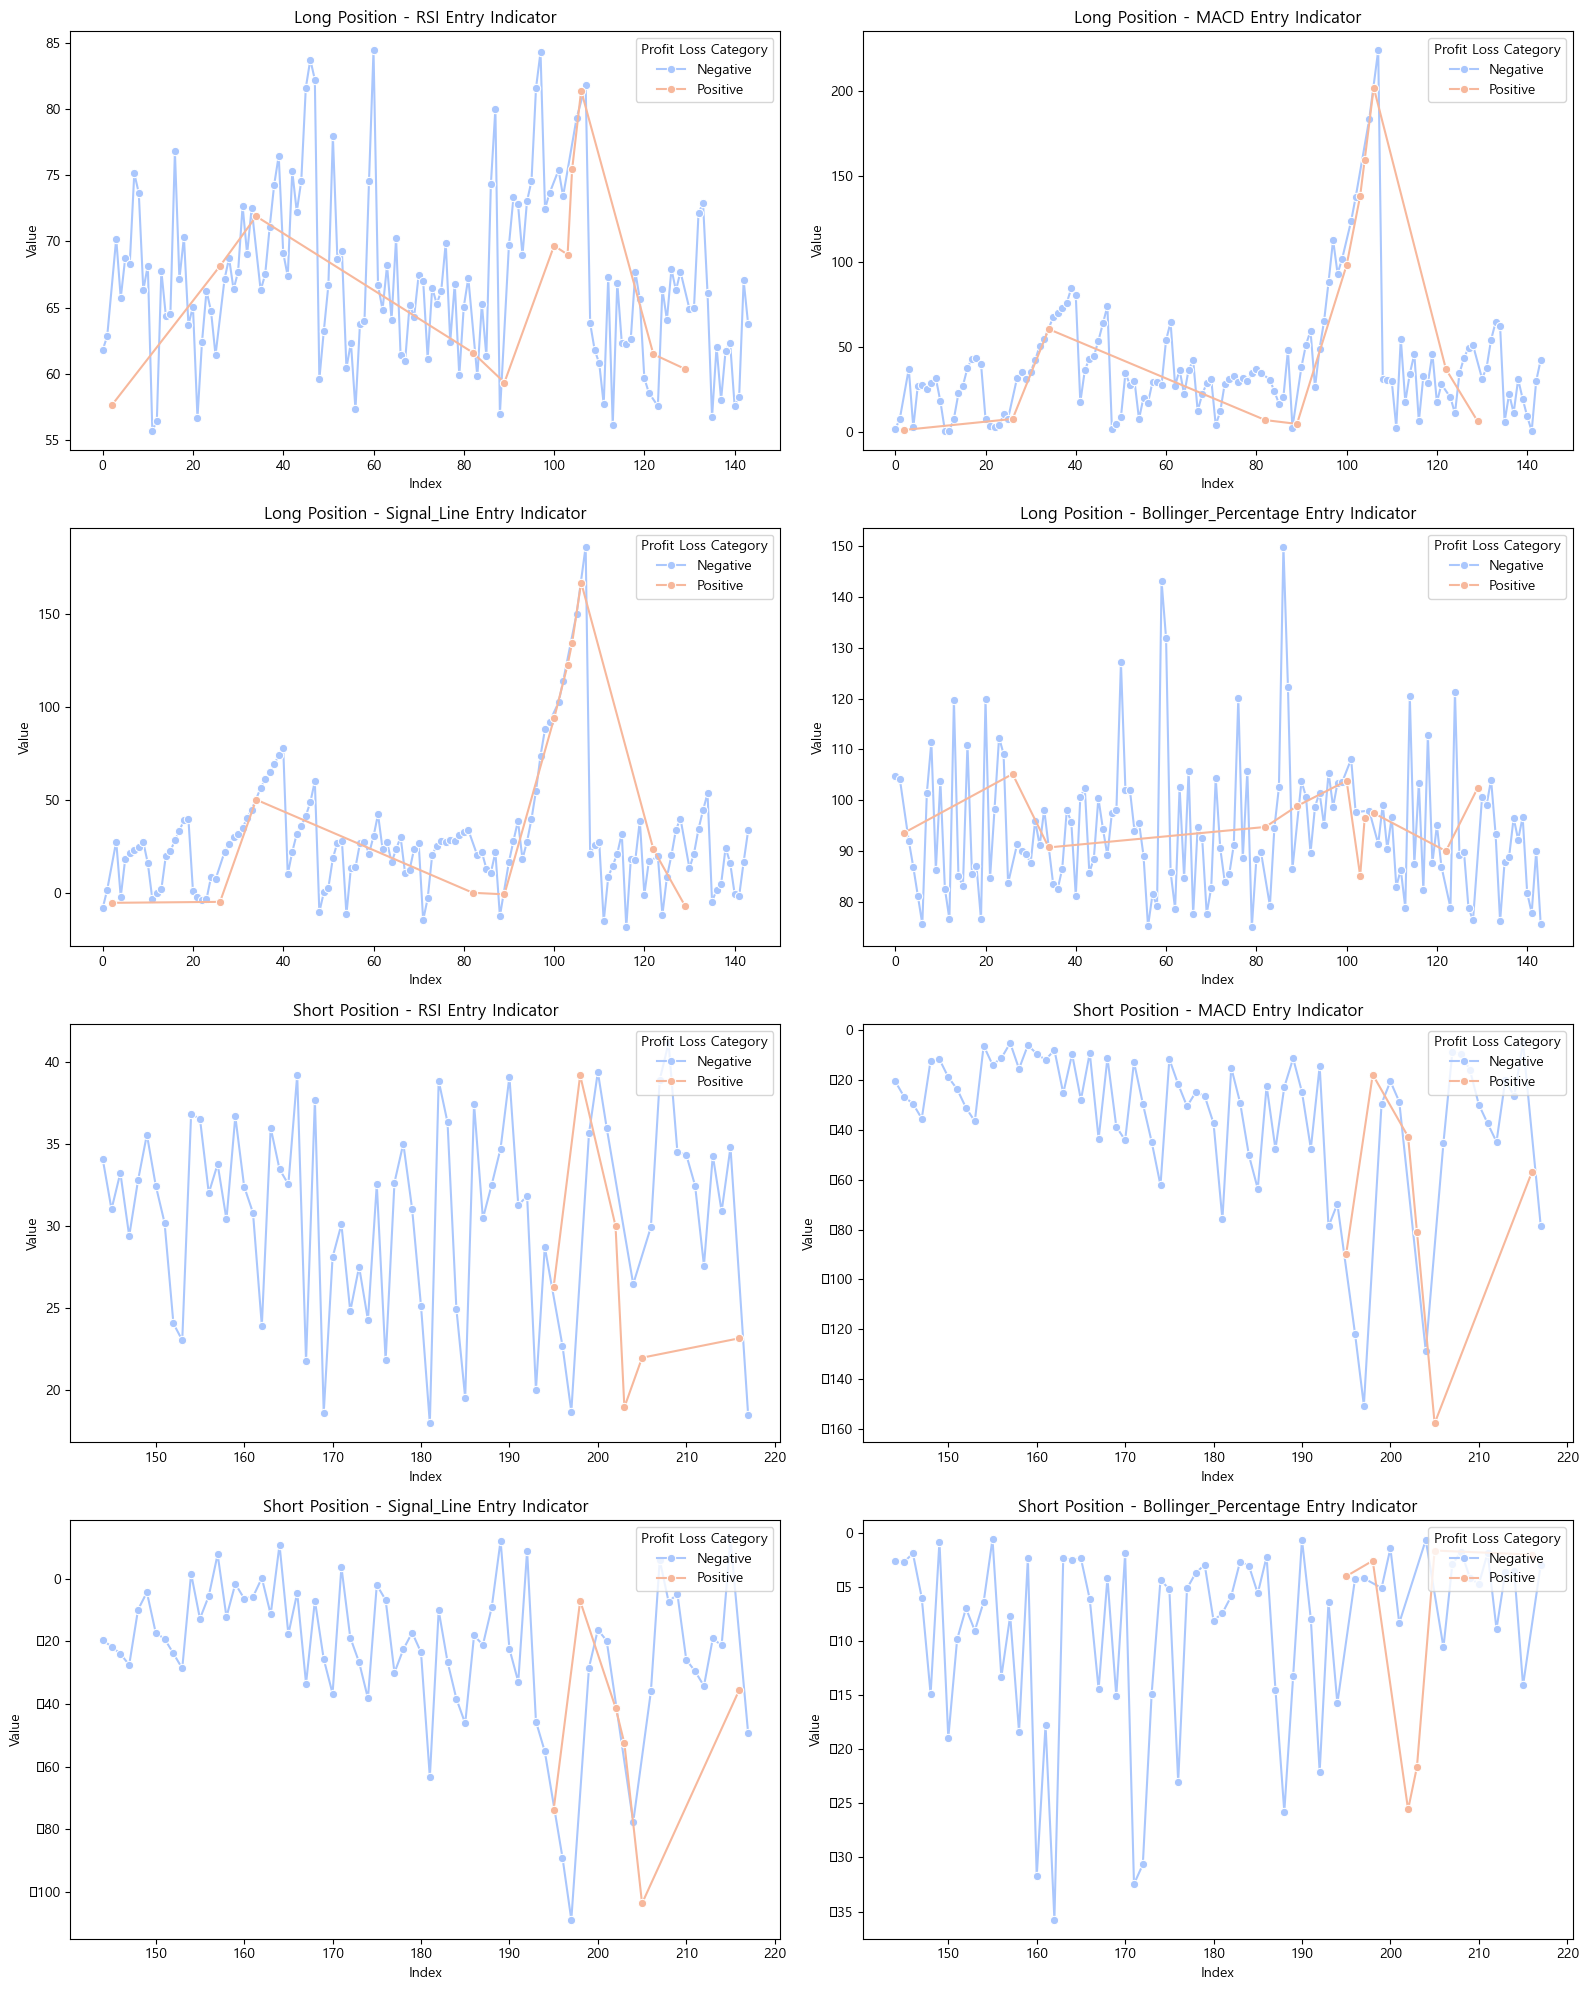

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups for entry, exit, and max profit
entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line", "Entry_Bollinger_Percentage"]

# Melt the data to include entry indicators
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=entry_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 4 graphs (Long and Short positions separated for each indicator)
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs_entry = {
    "RSI": ["Entry_RSI"],
    "MACD": ["Entry_MACD"],
    "Signal_Line": ["Entry_Signal_Line"],
    "Bollinger_Percentage": ["Entry_Bollinger_Percentage"]
}

# Loop through positions and entry indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific entry indicator
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs_entry[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Entry Indicator")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()
